In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

In [350]:
data = pd.read_excel("data1.xlsx")
data.head()

,motor_load_series,active_power_series,motor_temperature_series,input_pressure_series,g4_oc_series,vibration_axis_series,Class
0,66.232459,87.045404,29.990611,12.457477,26.265977,0.146433,0
1,99.425626,80.863439,30.541214,15.592534,27.340387,0.260986,0
2,56.152636,81.015949,31.564880,17.205926,21.822926,0.185072,0
3,97.082144,97.565727,29.631335,15.865803,28.788639,0.453265,0
4,59.714174,86.907902,29.223181,16.405030,21.307266,0.350902,0


In [351]:
data.describe()

,motor_load_series,active_power_series,motor_temperature_series,input_pressure_series,g4_oc_series,vibration_axis_series,Class
count,4973.000000,4973.000000,4973.000000,4973.000000,4973.000000,4973.000000,4973.000000
mean,76.827814,91.512626,30.081126,14.902787,25.031170,0.306793,0.195858
std,15.215403,6.390319,1.022400,2.930170,2.870612,0.117030,0.396899
min,50.005360,80.005562,26.399279,8.417792,20.001270,0.100042,0.000000
25%,64.128481,86.222820,29.384230,12.428648,22.580162,0.207579,0.000000
50%,76.804233,91.542122,30.087619,15.000144,25.104749,0.306336,0.000000
75%,89.415596,96.534412,30.789562,17.385855,27.518854,0.405898,0.000000
max,117.491795,109.434627,33.704616,19.999862,29.998741,0.647756,1.000000


In [352]:
#y transformation
LE = LabelEncoder().fit(y)
y = LE.transform(y)
print(np.sum(y))

974


In [353]:
X, y = data.drop('Class', axis=1).copy(), data['Class'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X.tail())


      motor_load_series  active_power_series  motor_temperature_series  \
4968         103.019509           100.190269                 31.479949   
4969          70.343728           108.226330                 31.998530   
4970          87.142013            99.291652                 31.655532   
4971         117.449265           105.509555                 31.742041   
4972          78.056525           100.449675                 31.839638   

      input_pressure_series  g4_oc_series  vibration_axis_series  
4968              18.985613     23.693588               0.414827  
4969              14.639448     24.548737               0.309136  
4970              12.882917     27.724087               0.290953  
4971              15.050675     29.997798               0.289523  
4972              16.936519     21.819081               0.316219  


# Model training



In [355]:
models_dict = {}

## One Rule

In [361]:
from mlxtend.classifier import OneRClassifier
X_train_OneR = X_train.copy()
n_bins = 3
labels = [i for i in range(1, n_bins+1)]
for col in data.drop('Class', axis=1).copy():
    X_train_OneR[col] = pd.cut(X_train_OneR[col], bins=n_bins, labels=labels)
X_train_OneR = X_train_OneR.to_numpy()
OneR = OneRClassifier().fit(X_train_OneR, y_train)
y_pred = OneR.predict(X_test.to_numpy())
print(f'Accuracy: {(y_pred == y_test).mean()}')
models_dict['OneR'] = OneR

Accuracy: 0.8130653266331658


## LogisticRegression

In [365]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(max_iter=200).fit(X_train, y_train)
print(
f'''Accuracy: {LogReg.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1])}'''
)
models_dict['LogReg'] = LogReg

Accuracy: 0.8502512562814071
roc_auc score 0.8294057445140024


## KNN

In [368]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier().fit(X_train, y_train)
print(
f'''Accuracy: {KNN.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, KNN.predict_proba(X_test)[:, 1])}'''
)
models_dict['KNN'] = KNN

Accuracy: 0.8623115577889447
roc_auc score 0.7691062907877773


## Bayes Classifier

In [371]:
from sklearn.naive_bayes import CategoricalNB
MrBayes = CategoricalNB(min_categories=X.nunique()).fit(X_train, y_train)
print(
f'''Accuracy: {MrBayes.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MrBayes.predict_proba(X_test)[:, 1])}'''
)
models_dict['Bayes'] = MrBayes

Accuracy: 0.8371859296482412
roc_auc score 0.8737057564762019


## DescisionTree

In [374]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15).fit(X_train, y_train)
print(
f'''train acc {(tree.predict(X_train) == y_train).mean()}
test acc {(tree.predict(X_test) == y_test).mean()}
'''
)
models_dict['tree'] = tree

train acc 0.9198089492207139
test acc 0.8894472361809045



## Boosting

In [377]:
from catboost import CatBoostClassifier, Pool
test_pool = Pool(X_test, y_test)

boosting = CatBoostClassifier(iterations=200,
                           depth=8,
                           learning_rate=0.001,
                           loss_function='Logloss',
                           task_type='GPU',
                           verbose=False)
# train the model
boosting.fit(X_train, y_train)
# make the prediction using the resulting model
preds_class = boosting.predict(test_pool)
preds_proba = boosting.predict_proba(test_pool)
score = boosting.score(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)
print("score = ", score)
models_dict['CatBoost'] = boosting


class =  [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0

## SVC

In [379]:
from sklearn.svm import SVC
vector_classif = SVC(cache_size=2048).fit(X_train, y_train)
print(
f'''Accuracy: {vector_classif.score(X_test, y_test)}'''
)
models_dict['SVM'] = vector_classif


Accuracy: 0.84321608040201


# MLP

In [381]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(30,), learning_rate='adaptive').fit(X_train, y_train)
print(
f'''Accuracy: {MLP.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MLP.predict_proba(X_test)[:, 1])}'''
)
models_dict['MLP'] = MLP


Accuracy: 0.8331658291457287
roc_auc score 0.757725587144623


## Ensemble

In [383]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=51, 
                                criterion='entropy', 
                                max_depth=15)
forest.fit(X_train, y_train)
print(
f'''train acc {(forest.predict(X_train) == y_train).mean()}
test acc {(forest.predict(X_test) == y_test).mean()}'''
)
models_dict['RandomForest'] = forest 


train acc 0.9115133232780291
test acc 0.9055276381909547


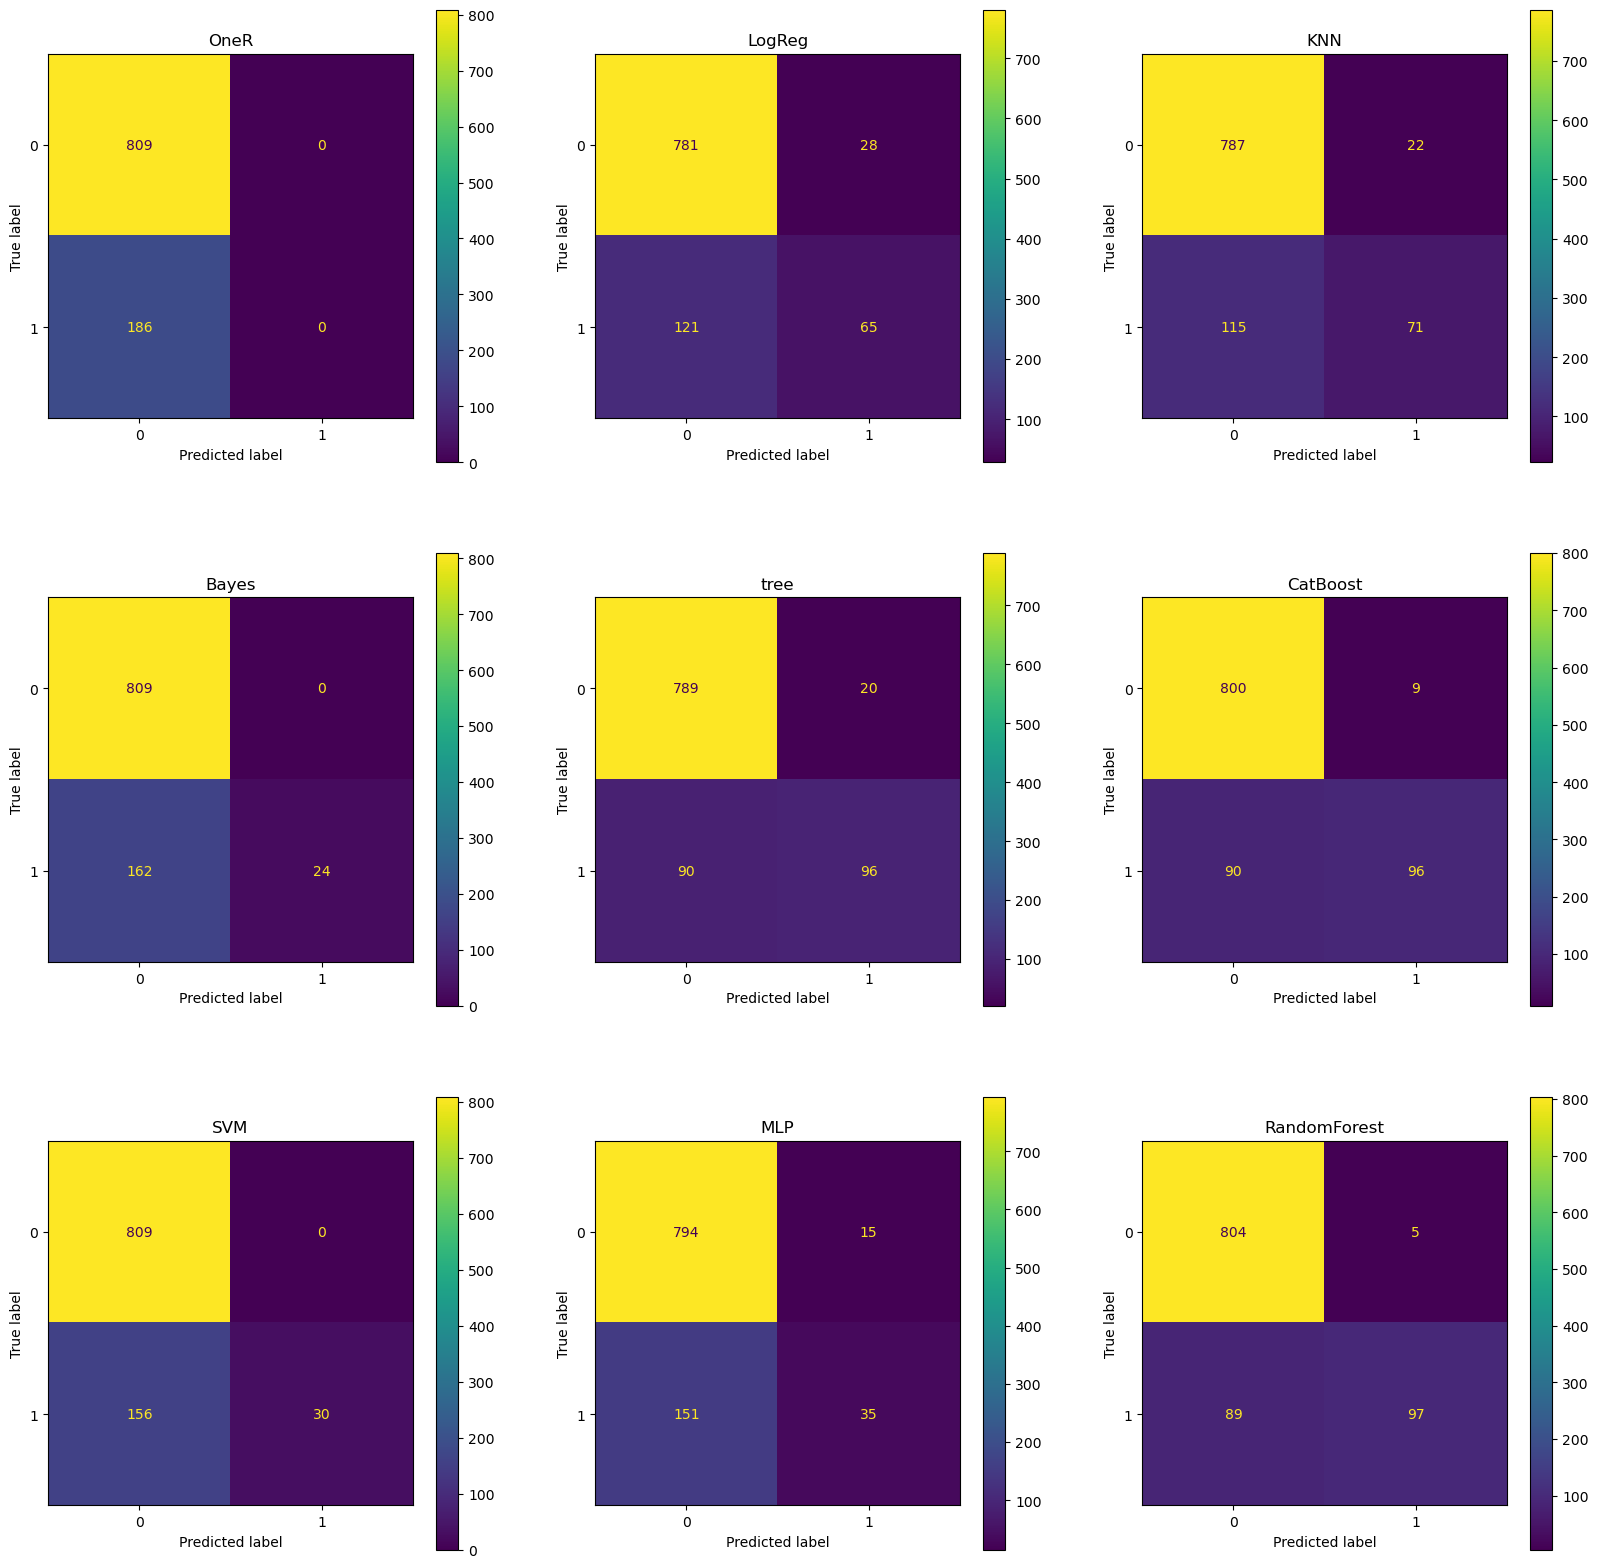

In [384]:
#confusion matrix
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
counter = 0
for i in range(3):
    for j in range(3):
        name, model = list(models_dict.items())[counter]
        y_pred = model.predict(X_test.to_numpy()) if name == 'OneR' else model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        ax[i][j].set_title(name)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LE.classes_).plot(ax=ax[i][j])
        counter+=1

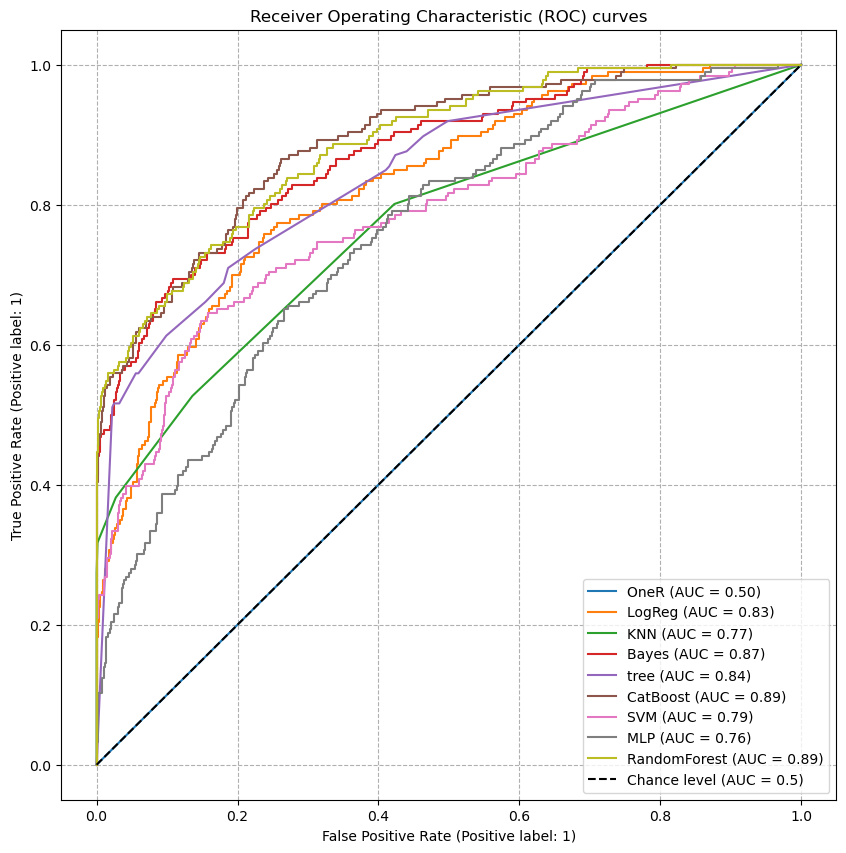

In [385]:
#roc auc curve
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for name, model in models_dict.items():
    if name == 'OneR':
        y_pred = model.predict(X_test.to_numpy())
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=ax) if name == 'OneR' else RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
ax.plot((0, 1), (0, 1), 
        label="Chance level (AUC = 0.5)",
        color="k",
        linestyle="--",)
ax.legend()
ax.set_title("Receiver Operating Characteristic (ROC) curves")
ax.grid(linestyle="--")